## 1. Inspect GRIB File

This cell opens the GRIB file and prints its metadata to give us a basic understanding of its structure, including dimensions, coordinates, and variables.

In [3]:
import xarray as xr
import pandas as pd
import logging
import os

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Define the path to the GRIB file
file_name = '/Users/dikshabhati/phd_work/climate_variable/data/total_prec_1990_2025_one_dataPoint_per_day.grib'

def inspect_grib_file(file_path):
    if not os.path.exists(file_path):
        logging.error(f"File not found: {file_path}")
        return None
    
    logging.info(f"Opening GRIB file: {file_path}")
    try:
        with xr.open_dataset(file_path, engine='cfgrib') as ds:
            print("--- GRIB File Metadata ---")
            print(f"Dimensions: {ds.dims}")
            print(f"Coordinates: {list(ds.coords.keys())}")
            print(f"Data variables: {list(ds.data_vars.keys())}")
            
            for var in ds.data_vars:
                print(f"\nVariable '{var}':")
                print(f"  Attributes: {ds[var].attrs}")
            
            print("--------------------------")
            return ds
    except Exception as e:
        logging.error(f"Failed to open or inspect GRIB file: {e}")
        return None

ds = inspect_grib_file(file_name)

2025-07-28 12:29:54,203 - INFO - Opening GRIB file: /Users/dikshabhati/phd_work/climate_variable/data/total_prec_1990_2025_one_dataPoint_per_day.grib
2025-07-28 12:29:54,912 - WARNING - Ignoring index file '/Users/dikshabhati/phd_work/climate_variable/data/total_prec_1990_2025_one_dataPoint_per_day.grib.5b7b6.idx' incompatible with GRIB file


--- GRIB File Metadata ---
Dimensions: FrozenMappingWarningOnValuesAccess({'time': 12984, 'latitude': 17, 'longitude': 22})
Coordinates: ['number', 'time', 'step', 'surface', 'latitude', 'longitude', 'valid_time']
Data variables: ['tp']

Variable 'tp':
  Attributes: {'GRIB_paramId': 228, 'GRIB_dataType': 'fc', 'GRIB_numberOfPoints': 374, 'GRIB_typeOfLevel': 'surface', 'GRIB_stepUnits': 1, 'GRIB_stepType': 'accum', 'GRIB_gridType': 'regular_ll', 'GRIB_uvRelativeToGrid': 0, 'GRIB_NV': 0, 'GRIB_Nx': 22, 'GRIB_Ny': 17, 'GRIB_cfName': 'unknown', 'GRIB_cfVarName': 'tp', 'GRIB_gridDefinitionDescription': 'Latitude/Longitude Grid', 'GRIB_iDirectionIncrementInDegrees': 0.25, 'GRIB_iScansNegatively': 0, 'GRIB_jDirectionIncrementInDegrees': 0.25, 'GRIB_jPointsAreConsecutive': 0, 'GRIB_jScansPositively': 0, 'GRIB_latitudeOfFirstGridPointInDegrees': 36.15, 'GRIB_latitudeOfLastGridPointInDegrees': 32.15, 'GRIB_longitudeOfFirstGridPointInDegrees': 75.5, 'GRIB_longitudeOfLastGridPointInDegrees': 80.75

/Users/dikshabhati/phd_work/climate_variable/.venv/lib/python3.13/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


In [4]:
def convert_grib_to_csv(ds, output_csv_path):
    """
    Converts an xarray Dataset to a pandas DataFrame and saves it as a CSV.
    
    Parameters:
    -----------
    ds : xarray.Dataset
        The dataset to convert.
    output_csv_path : str
        The path for the output CSV file.
    """
    logging.info("Converting dataset to DataFrame...")
    try:
        df = ds.to_dataframe()
        df = df.reset_index()
        
        logging.info("--- DataFrame Info ---")
        df.info(verbose=False, buf=logging.getLogger().handlers[0].stream)
        logging.info("----------------------")
        
        logging.info(f"--- DataFrame Head ---\n{df.head().to_string()}")
        logging.info("----------------------")

        logging.info(f"Saving DataFrame to {output_csv_path}...")
        df.to_csv(output_csv_path, index=False)
        logging.info(f"Successfully converted GRIB file to {output_csv_path}")
        
    except Exception as e:
        logging.error(f"Failed to convert or save DataFrame: {e}")


## 2. Convert to DataFrame and Prepare Data

Now, we'll convert the `xarray` Dataset into a `pandas` DataFrame, which is easier to work with for time series analysis. We will then process it to create an annual precipitation time series.

In [45]:
if ds:
    df = ds.to_dataframe().reset_index()
    print("Successfully converted to DataFrame.")
    
    # Ensure 'time' column is datetime
    df['time'] = pd.to_datetime(df['time'])
    
    # Set time as index
    df.set_index('time', inplace=True)
    
    # Aggregate to annual total precipitation (assuming 'tp' is the variable)
    # The data is in meters, so multiply by 1000 to get mm
    annual_precip = df['tp'].resample('Y').sum() * 1000
    
    print("\nAnnual Precipitation (mm):")
    print(annual_precip.head())
else:
    print("Dataset not loaded. Cannot proceed.")

Dataset not loaded. Cannot proceed.


## 3. Long-term Trend and Variability Analysis

This section performs the core analysis:
1.  **Trend Analysis**: Uses the Mann-Kendall test to check for a monotonic trend and Sen's slope to estimate the magnitude of the trend.
2.  **Inter-annual Variability**: Calculates the coefficient of variation and standardized anomalies.
3.  **Change-Point Detection**: Uses the Pelt algorithm to identify years where the statistical properties of the time series change, indicating potential climate regime shifts.

In [46]:
import pymannkendall as mk
import ruptures as rpt
import numpy as np

# 1. Trend Analysis
print("--- Trend Analysis ---")
mk_result = mk.original_test(annual_precip)
print(f"Mann-Kendall Test Result:")
print(f"  Trend: {mk_result.trend}")
print(f"  p-value: {mk_result.p:.4f}")
print(f"  Sen's Slope (mm/year): {mk_result.slope:.4f}")

# 2. Inter-annual Variability
print("\n--- Inter-annual Variability ---")
mean_annual = annual_precip.mean()
std_annual = annual_precip.std()
cv = (std_annual / mean_annual) * 100 if mean_annual > 0 else 0
standardized_anomalies = (annual_precip - mean_annual) / std_annual
print(f"Mean Annual Precipitation: {mean_annual:.2f} mm")
print(f"Standard Deviation: {std_annual:.2f} mm")
print(f"Coefficient of Variation (CV): {cv:.2f}%")

# 3. Change-Point Detection
print("\n--- Change-Point Detection ---")
points = annual_precip.values
algo = rpt.Pelt(model="rbf").fit(points)
change_points_indices = algo.predict(pen=10) # The 'pen' parameter can be tuned

if change_points_indices[-1] == len(points):
    change_points_indices = change_points_indices[:-1]

change_years = [annual_precip.index[i-1].year for i in change_points_indices]
print(f"Detected change points in the years: {change_years}")

--- Trend Analysis ---
Mann-Kendall Test Result:
  Trend: no trend
  p-value: 0.0967
  Sen's Slope (mm/year): -30.9444

--- Inter-annual Variability ---
Mean Annual Precipitation: 7291.88 mm
Standard Deviation: 1709.54 mm
Coefficient of Variation (CV): 23.44%

--- Change-Point Detection ---
Detected change points in the years: []


## 4. Visualization of Trends and Variability

Visualizing the results helps in understanding the trends, variability, and shifts more intuitively.

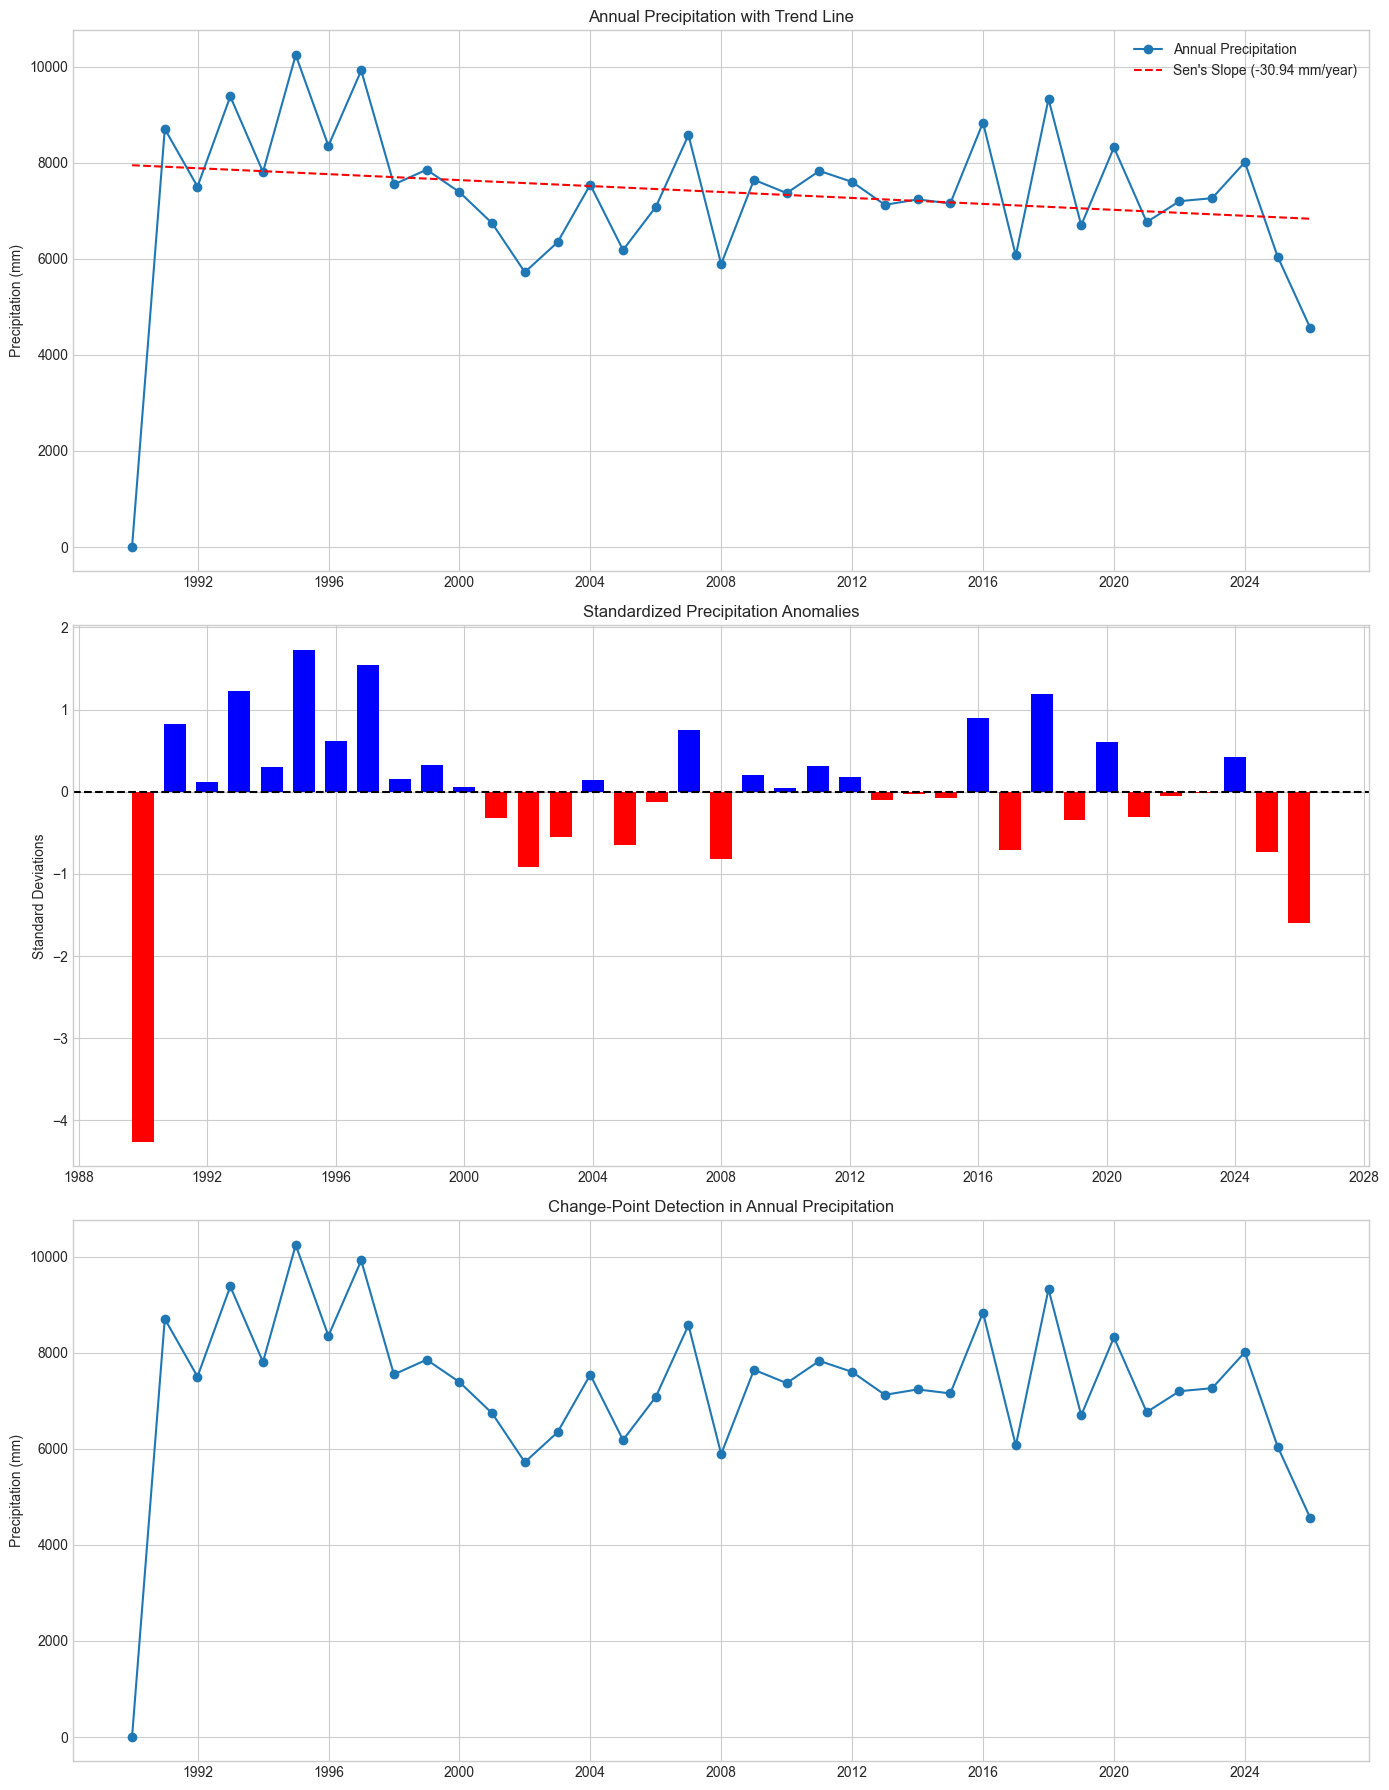

In [47]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(3, 1, figsize=(14, 18))

# Plot 1: Annual Precipitation with Trend Line
axes[0].plot(annual_precip.index, annual_precip.values, marker='o', linestyle='-', label='Annual Precipitation')
trend_line = mk_result.intercept + mk_result.slope * np.arange(len(annual_precip))
axes[0].plot(annual_precip.index, trend_line, color='red', linestyle='--', label=f"Sen's Slope ({mk_result.slope:.2f} mm/year)")
axes[0].set_title('Annual Precipitation with Trend Line')
axes[0].set_ylabel('Precipitation (mm)')
axes[0].legend()

# Plot 2: Standardized Anomalies
colors = ['red' if x < 0 else 'blue' for x in standardized_anomalies]
axes[1].bar(standardized_anomalies.index, standardized_anomalies.values, color=colors, width=250)
axes[1].axhline(0, color='black', linestyle='--')
axes[1].set_title('Standardized Precipitation Anomalies')
axes[1].set_ylabel('Standard Deviations')

# Plot 3: Change-Point Detection
axes[2].plot(annual_precip.index, annual_precip.values, marker='o', linestyle='-')
for year_index in change_points_indices:
    axes[2].axvline(annual_precip.index[year_index-1], color='r', linestyle='--', lw=2, label=f'Change at {annual_precip.index[year_index-1].year}')
axes[2].set_title('Change-Point Detection in Annual Precipitation')
axes[2].set_ylabel('Precipitation (mm)')
if change_points_indices:
    handles, labels = axes[2].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    axes[2].legend(by_label.values(), by_label.keys())

plt.tight_layout()
plt.show()

## 5. Seasonal Dynamics Analysis

This section defines the seasons based on the Indian Meteorological Department (IMD) classification, calculates seasonal precipitation totals, and analyzes trends within each season.

In [48]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Pre-Monsoon'
    elif month in [6, 7, 8, 9]:
        return 'Monsoon'
    elif month in [10, 11]:
        return 'Post-Monsoon'

daily_precip = df['tp'] * 1000
daily_precip.index.name = 'time'
df_daily = daily_precip.reset_index()
df_daily['season'] = df_daily['time'].dt.month.apply(get_season)

seasonal_precip = df_daily.groupby([df_daily['time'].dt.year, 'season'])['tp'].sum().unstack()

print("--- Seasonal Precipitation Totals (mm) ---")
print(seasonal_precip.head())

print("\n--- Seasonal Trend Analysis ---")
for season in seasonal_precip.columns:
    mk_result_seasonal = mk.original_test(seasonal_precip[season].dropna())
    print(f"\nTrend for {season} season:")
    print(f"  Trend: {mk_result_seasonal.trend}")
    print(f"  p-value: {mk_result_seasonal.p:.4f}")
    print(f"  Sen's Slope (mm/year): {mk_result_seasonal.slope:.4f}")

--- Seasonal Precipitation Totals (mm) ---
season      Monsoon  Post-Monsoon  Pre-Monsoon       Winter
time                                                       
1989            NaN           NaN          NaN    11.315338
1990    2393.369873    279.730652  2334.799805  3694.399658
1991    1948.290039    370.609161  3026.359131  2156.055908
1992    3077.251709    450.043365  2989.025146  2862.594727
1993    3042.669189    791.132996  2354.699463  1617.075195

--- Seasonal Trend Analysis ---

Trend for Monsoon season:
  Trend: no trend
  p-value: 0.7958
  Sen's Slope (mm/year): 2.1223

Trend for Post-Monsoon season:
  Trend: no trend
  p-value: 0.6092
  Sen's Slope (mm/year): 2.3052

Trend for Pre-Monsoon season:
  Trend: decreasing
  p-value: 0.0127
  Sen's Slope (mm/year): -26.9248

Trend for Winter season:
  Trend: no trend
  p-value: 0.4403
  Sen's Slope (mm/year): -11.2241


## 6. Monsoon Onset, Withdrawal, and Intra-seasonal Variability

This section analyzes the timing of the monsoon and its internal variability using pentad (5-day) aggregations.

In [49]:
# Monsoon Intensity
monsoon_intensity = seasonal_precip['Monsoon']
print("--- Monsoon Intensity (Total Seasonal Precipitation) ---")
print(monsoon_intensity.head())

# Intra-seasonal (Pentad) Analysis
pentad_precip = daily_precip.resample('5D').sum()
pentad_climatology = pentad_precip.groupby(pentad_precip.index.dayofyear // 5).mean()

print("\n--- Average Pentad Precipitation (mm) ---")
print(pentad_climatology.head())

--- Monsoon Intensity (Total Seasonal Precipitation) ---
time
1989            NaN
1990    2393.369873
1991    1948.290039
1992    3077.251709
1993    3042.669189
Name: Monsoon, dtype: float32

--- Average Pentad Precipitation (mm) ---
time
0    126.942223
1    109.144119
2    111.334206
3    124.144585
4    117.749672
Name: tp, dtype: float32


## 7. Visualization of Seasonal Dynamics

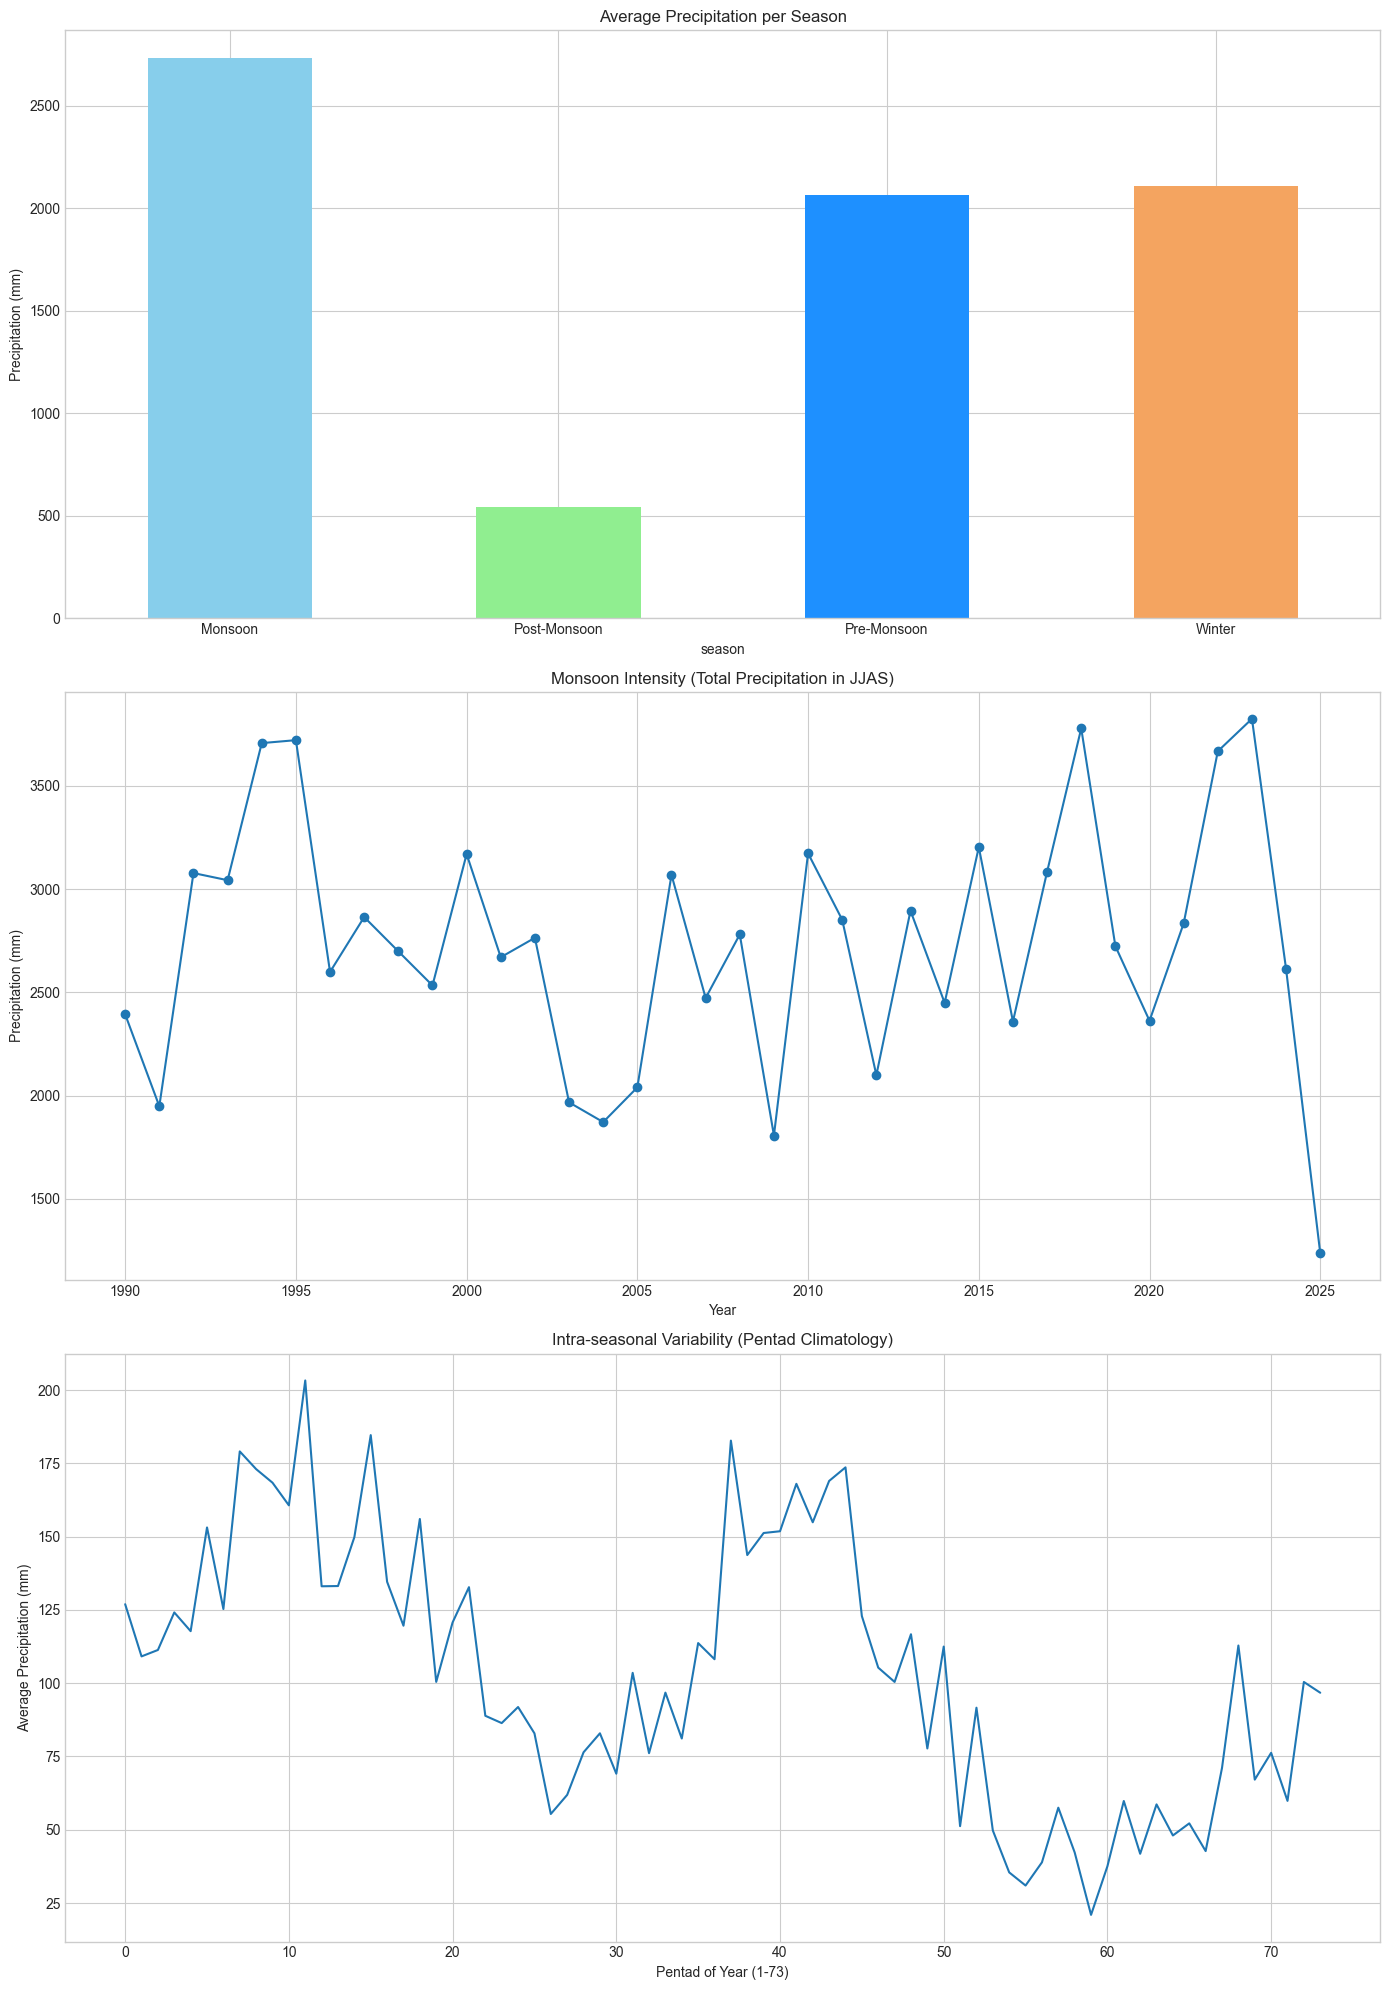

In [50]:
fig, axes = plt.subplots(3, 1, figsize=(14, 20))

# Plot 1: Seasonal Precipitation Climatology
seasonal_precip.mean().plot(kind='bar', ax=axes[0], color=['skyblue', 'lightgreen', 'dodgerblue', 'sandybrown'])
axes[0].set_title('Average Precipitation per Season')
axes[0].set_ylabel('Precipitation (mm)')
axes[0].tick_params(axis='x', rotation=0)

# Plot 2: Monsoon Intensity Over Time
axes[1].plot(monsoon_intensity.index, monsoon_intensity.values, marker='o', linestyle='-')
axes[1].set_title('Monsoon Intensity (Total Precipitation in JJAS)')
axes[1].set_ylabel('Precipitation (mm)')
axes[1].set_xlabel('Year')

# Plot 3: Pentad Climatology
axes[2].plot(pentad_climatology.index, pentad_climatology.values)
axes[2].set_title('Intra-seasonal Variability (Pentad Climatology)')
axes[2].set_xlabel('Pentad of Year (1-73)')
axes[2].set_ylabel('Average Precipitation (mm)')

plt.tight_layout()
plt.show()

In [51]:
def trend_analysis(x):
    if np.all(np.isnan(x)):
        return np.nan
    # Theil-Sen slope is used to quantify the trend
    result = mk.original_test(x)
    return result.slope

def create_tiff_from_grib(grib_path, tif_path):
    """
    Reads a GRIB file, performs a trend analysis on the data, and saves the result as a GeoTIFF.
    """
    try:
        # Open the GRIB file
        print(f"Opening GRIB file: {grib_path}")
        ds = xr.open_dataset(grib_path, engine="cfgrib", chunks={'time': 'auto'})

        # Ensure the CRS is set correctly for rioxarray
        ds = ds.rio.set_crs("epsg:4326")

        # Resample to annual maximums, similar to the R script's logic
        print("Aggregating data to annual maximums...")
        annual_max = ds['tp'].resample(time='A').max(dim='time', skipna=True)

        # Rechunk the time dimension to fix the dask issue
        annual_max = annual_max.chunk(dict(time=-1))

        # Apply the trend analysis function across the time dimension
        print("Performing trend analysis...")
        trend_data = xr.apply_ufunc(
            trend_analysis,
            annual_max,
            input_core_dims=[['time']],
            output_core_dims=[[]],
            vectorize=True,
            dask="parallelized",
            output_dtypes=[float]
        )

        # Add CRS information to the output DataArray
        trend_data.rio.write_crs("epsg:4326", inplace=True)
        
        # Save the result as a GeoTIFF
        print(f"Saving trend analysis to TIFF: {tif_path}")
        trend_data.rio.to_raster(tif_path, driver="GTiff")

        print("Processing complete.")

    except Exception as e:
        print(f"An error occurred: {e}")


In [55]:
grib_file = 'data/total_prec_1990_2025_one_dataPoint_per_day.grib'
tiff_file = 'output/precipitation_trend.tif'
create_tiff_from_grib(grib_file, tiff_file)

Opening GRIB file: data/total_prec_1990_2025_one_dataPoint_per_day.grib
Aggregating data to annual maximums...
Performing trend analysis...
Saving trend analysis to TIFF: output/precipitation_trend.tif


/Users/dikshabhati/phd_work/climate_variable/.venv/lib/python3.13/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/var/folders/tg/t3mydgj97hg4cqlb461b2wrc0000gn/T/ipykernel_61552/2298872945.py:18: FutureWarning: It is recommended to use 'rio.write_crs()' instead. 'rio.set_crs()' will likelybe removed in a future release.
  ds = ds.rio.set_crs("epsg:43

Processing complete.


In [56]:
import rioxarray

def visualize_tiff(tiff_path, output_path):
    """
    Reads a GeoTIFF file and creates a visualization with a color bar.
    """
    try:
        # Open the TIFF file
        print(f"Opening TIFF file: {tiff_path}")
        trend_data = rioxarray.open_rasterio(tiff_path)

        # Create the plot
        print("Generating plot...")
        fig, ax = plt.subplots(1, 1, figsize=(10, 8))
        
        # Plot the data
        im = trend_data.plot(ax=ax, cmap='coolwarm', cbar_kwargs={'label': "Precipitation Trend (Sen's Slope)"})
        
        # Set plot titles and labels
        ax.set_title("Trend of Annual Maximum Precipitation (1990-2025)", fontsize=16)
        ax.set_xlabel("Longitude", fontsize=12)
        ax.set_ylabel("Latitude", fontsize=12)
        im.colorbar.set_label("Precipitation Trend (Sen's Slope in m/year)", fontsize=12)
        
        # Save the plot to a file
        print(f"Saving plot to: {output_path}")
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        
        print(f"Visualization saved successfully to {output_path}")

    except Exception as e:
        print(f"An error occurred: {e}")


Opening TIFF file: output/precipitation_trend.tif
Generating plot...
Saving plot to: output/precipitation_trend.png
Visualization saved successfully to output/precipitation_trend.png


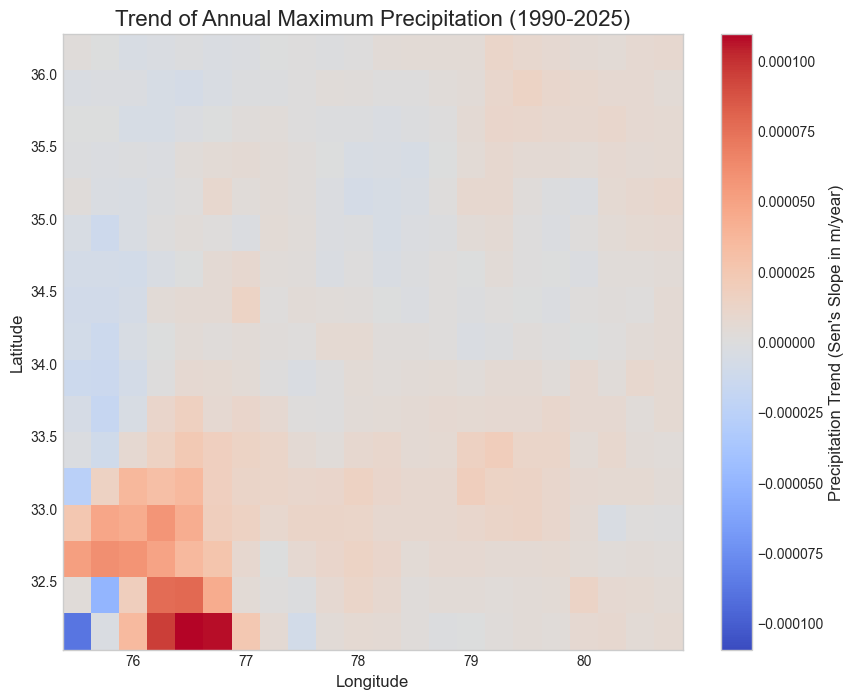

In [57]:
tiff_file = 'output/precipitation_trend.tif'
output_image = 'output/precipitation_trend.png'
visualize_tiff(tiff_file, output_image)

## 8. Extreme Event Characterization

This section focuses on extreme precipitation events. It involves fitting a Generalized Extreme Value (GEV) distribution to annual maxima to estimate return periods and calculating standard extreme precipitation indices.

In [40]:
from scipy.stats import genextreme
import lmoments3 as lm

print("--- Precipitation Extremes Analysis ---")
# GEV Analysis using Annual Maxima
annual_maxima = daily_precip.resample('Y').max()
params = lm.gev.lmom_fit(annual_maxima.dropna())
fitted_gev = genextreme(**params)

print(f"GEV Parameters (shape, loc, scale): {params}")

# Return Period Estimation
return_periods = [10, 20, 50, 100]
print("\nReturn Levels (mm):")
for rp in return_periods:
    level = fitted_gev.ppf(1 - 1/rp)
    print(f"  {rp}-year return level: {level:.2f} mm")

# Extreme Precipitation Indices
def calculate_r95p(series):
    p95 = series[series > 0].quantile(0.95)
    return series[series > p95].sum()

def calculate_cdd(series, threshold=1.0):
    is_dry = series < threshold
    return is_dry.cumsum().sub(is_dry.cumsum().where(~is_dry).ffill().fillna(0)).max()

def calculate_cwd(series, threshold=1.0):
    is_wet = series >= threshold
    return is_wet.cumsum().sub(is_wet.cumsum().where(~is_wet).ffill().fillna(0)).max()

extreme_indices = df_daily.groupby(df_daily['time'].dt.year)['tp'].agg(
    PRCPTOT='sum',
    R95p=calculate_r95p,
    CDD=calculate_cdd,
    CWD=calculate_cwd
)
print("\n--- Extreme Precipitation Indices (Annual) ---")
print(extreme_indices.head())

--- Precipitation Extremes Analysis ---


/var/folders/tg/t3mydgj97hg4cqlb461b2wrc0000gn/T/ipykernel_61552/2533125604.py:6: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_maxima = daily_precip.resample('Y').max()


AttributeError: module 'lmoments3' has no attribute 'gev'

## 9. Drought and Wet Spell Analysis (SPI)

This cell calculates the Standardized Precipitation Index (SPI) at 3, 6, and 12-month scales to characterize drought and wet periods.

In [41]:
from climate_indices import compute

monthly_precip = daily_precip.resample('M').sum()

print("--- Calculating SPI ---")
spi_3m = compute.spi(monthly_precip, scale=3, distribution=compute.Distribution.gamma, data_start_year=monthly_precip.index[0].year, calibration_year_initial=monthly_precip.index[0].year, calibration_year_final=monthly_precip.index[-1].year, period_of_record_start_year=monthly_precip.index[0].year)
spi_6m = compute.spi(monthly_precip, scale=6, distribution=compute.Distribution.gamma, data_start_year=monthly_precip.index[0].year, calibration_year_initial=monthly_precip.index[0].year, calibration_year_final=monthly_precip.index[-1].year, period_of_record_start_year=monthly_precip.index[0].year)
spi_12m = compute.spi(monthly_precip, scale=12, distribution=compute.Distribution.gamma, data_start_year=monthly_precip.index[0].year, calibration_year_initial=monthly_precip.index[0].year, calibration_year_final=monthly_precip.index[-1].year, period_of_record_start_year=monthly_precip.index[0].year)

spi_df = pd.DataFrame({'SPI_3': spi_3m, 'SPI_6': spi_6m, 'SPI_12': spi_12m}, index=monthly_precip.index)

print("\n--- SPI Values (3, 6, 12 months) ---")
print(spi_df.tail())

ImportError: Numba needs NumPy 2.2 or less. Got NumPy 2.3.

## 10. Visualization of Extreme Events

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(14, 14))

# Plot 1: GEV Fit and Return Levels
axes[0].hist(annual_maxima.dropna(), bins=20, density=True, alpha=0.6, label='Empirical Histogram')
x = np.linspace(fitted_gev.ppf(0.01), fitted_gev.ppf(0.99), 100)
axes[0].plot(x, fitted_gev.pdf(x), 'r-', lw=2, label='Fitted GEV PDF')
axes[0].set_title('GEV Distribution Fitted to Annual Maxima')
axes[0].set_xlabel('Annual Maximum Daily Precipitation (mm)')
axes[0].set_ylabel('Density')
axes[0].legend()

# Plot 2: SPI-12 Time Series
axes[1].plot(spi_df.index, spi_df['SPI_12'], label='SPI-12')
axes[1].axhline(0, linestyle='--', color='black')
axes[1].fill_between(spi_df.index, spi_df['SPI_12'], 0, where=spi_df['SPI_12'] <= -1, color='red', alpha=0.5, label='Drought')
axes[1].fill_between(spi_df.index, spi_df['SPI_12'], 0, where=spi_df['SPI_12'] >= 1, color='green', alpha=0.5, label='Wet')
axes[1].set_title('12-Month Standardized Precipitation Index (SPI-12)')
axes[1].set_ylabel('SPI Value')
axes[1].set_xlabel('Year')
axes[1].legend()

plt.tight_layout()
plt.show()

## 11. Spatial Pattern Analysis (EOF)

Empirical Orthogonal Function (EOF) analysis helps to identify the dominant spatial patterns (modes) of variability in the precipitation data. We will use the original `xarray.Dataset` for this, as it preserves the spatial grid.

In [42]:
from eofs.xarray import Eof
import cartopy.crs as ccrs

if ds:
    # We use monthly anomalies to focus on variability, not the mean seasonal cycle
    monthly_data = ds['tp'].resample(time='1M').mean()
    climatology = monthly_data.groupby('time.month').mean('time')
    anomalies = monthly_data.groupby('time.month') - climatology
    
    # Create an EOF solver
    # The weights are the square root of the cosine of latitude, for area-weighting
    coslat = np.cos(np.deg2rad(anomalies.coords['latitude'].values)).clip(0., 1.)
    wgts = np.sqrt(coslat)[..., np.newaxis]
    solver = Eof(anomalies, weights=wgts)
    
    # Retrieve the leading EOFs and PCs
    eofs = solver.eofs(neofs=3)
    pcs = solver.pcs(npcs=3, pcscaling=1)
    variance_fractions = solver.varianceFraction(neigs=3)
    
    print("--- EOF Analysis ---")
    print(f"Variance explained by 1st EOF: {variance_fractions.values[0]*100:.2f}%")
    print(f"Variance explained by 2nd EOF: {variance_fractions.values[1]*100:.2f}%")
    print(f"Variance explained by 3rd EOF: {variance_fractions.values[2]*100:.2f}%")
else:
    print("Dataset not loaded. Cannot perform EOF analysis.")

--- EOF Analysis ---
Variance explained by 1st EOF: 59.55%
Variance explained by 2nd EOF: 14.26%
Variance explained by 3rd EOF: 6.09%


/Users/dikshabhati/phd_work/climate_variable/.venv/lib/python3.13/site-packages/xarray/groupers.py:509: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


## 12. Visualization of Dominant Spatial Mode (EOF1)

/Users/dikshabhati/phd_work/climate_variable/.venv/lib/python3.13/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


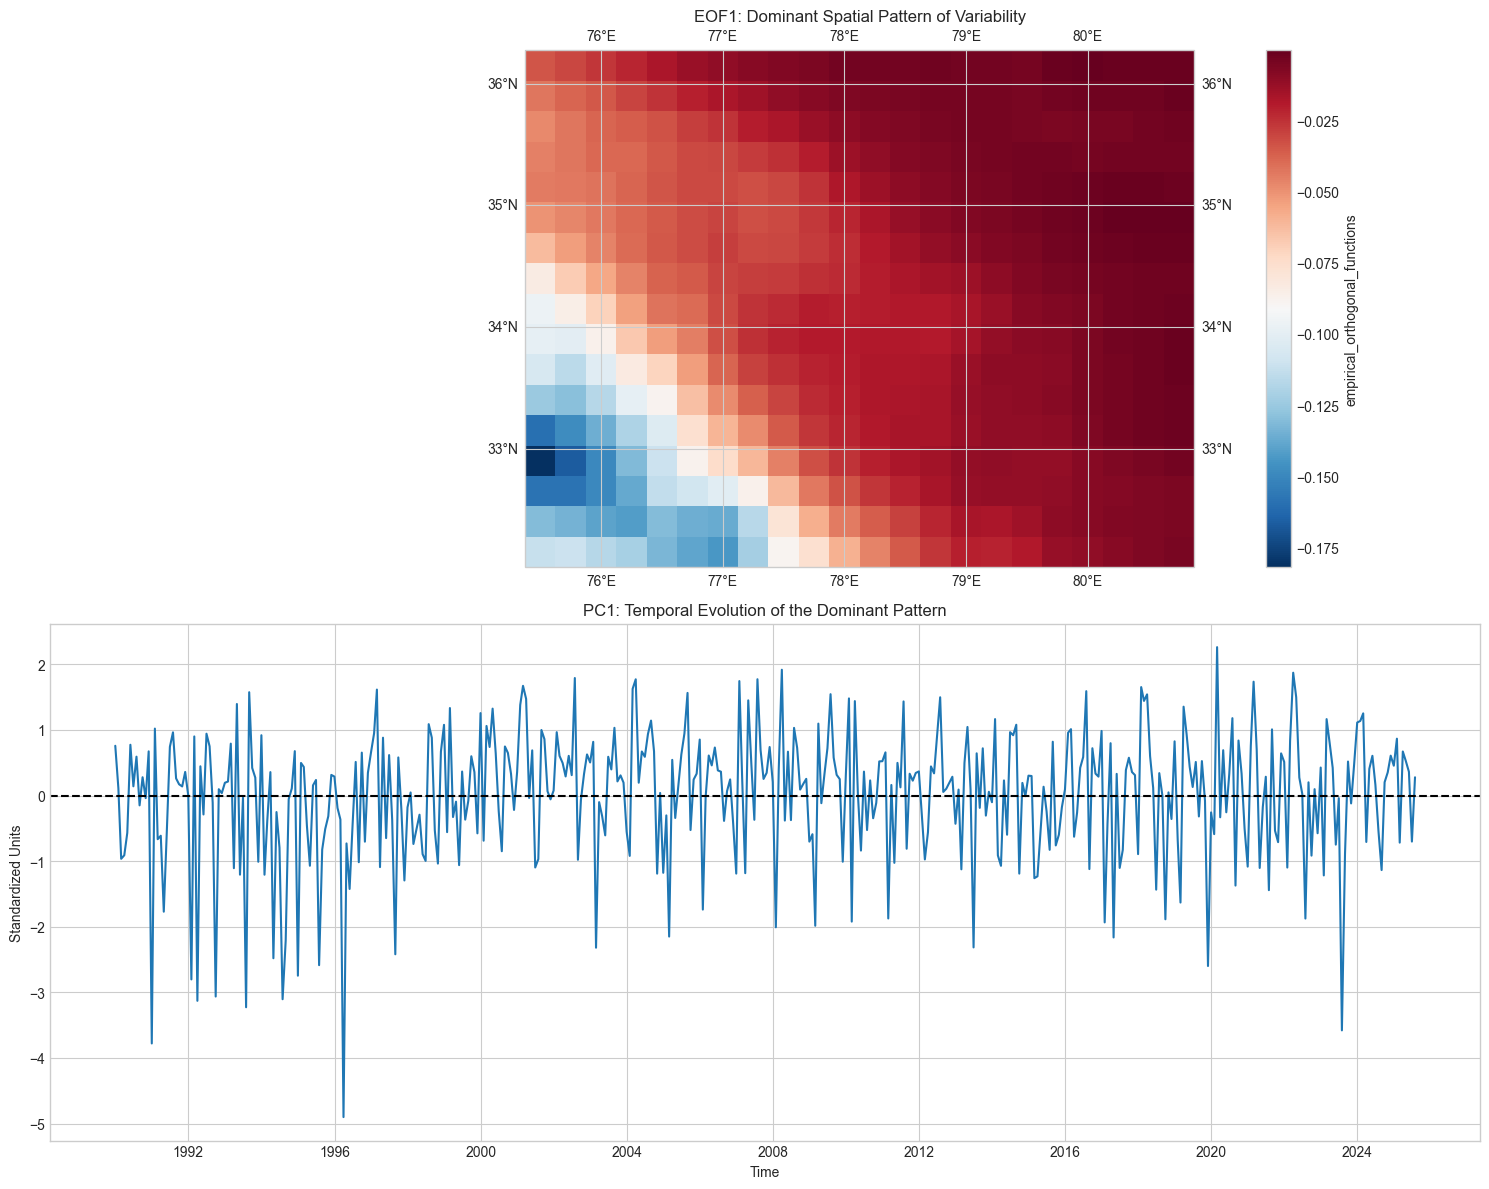

In [43]:
if ds:
    fig = plt.figure(figsize=(15, 12))

    # Plot the first EOF pattern
    ax1 = fig.add_subplot(2, 1, 1, projection=ccrs.PlateCarree())
    eofs[0].plot(ax=ax1, cmap='RdBu_r', transform=ccrs.PlateCarree())
    ax1.coastlines()
    ax1.gridlines(draw_labels=True)
    ax1.set_title('EOF1: Dominant Spatial Pattern of Variability')

    # Plot the first Principal Component (PC) time series
    ax2 = fig.add_subplot(2, 1, 2)
    pcs[:, 0].plot(ax=ax2)
    ax2.axhline(0, color='k', linestyle='--')
    ax2.set_title('PC1: Temporal Evolution of the Dominant Pattern')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Standardized Units')

    plt.tight_layout()
    plt.show()
else:
    print("EOF analysis not performed. Cannot visualize.")